# Chapter 6 Tree-based methods
## 6.1 Simple trees

In [52]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


In [111]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # will be used later in the notebook for classification tasks
data_ml

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd,R1M_Usd_C
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.27,1.00,0.92,0.84,0.88,0.089,0.104,0.344,-0.041,1
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.27,1.00,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253,1
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.27,1.00,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366,0
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.75,1.00,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376,1
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.75,1.00,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283375,1205,2004-05-31,0.97,0.97,0.98,0.19,0.74,1.00,0.54,0.90,...,0.99,0.57,0.59,0.34,0.63,-0.029,-0.027,0.038,0.112,0
283376,1205,2004-07-31,0.97,0.96,0.98,0.19,0.75,1.00,0.53,0.90,...,0.99,0.58,0.60,0.29,0.64,0.028,0.077,0.175,0.122,1
283377,1205,2004-08-31,0.97,0.96,0.97,0.19,0.75,1.00,0.53,0.90,...,0.99,0.58,0.60,0.27,0.64,0.011,0.076,0.152,0.091,1
283378,1205,2004-09-30,0.97,0.96,0.97,0.18,0.93,1.00,0.52,0.90,...,0.99,0.57,0.60,0.26,0.66,0.045,0.178,0.196,0.040,1


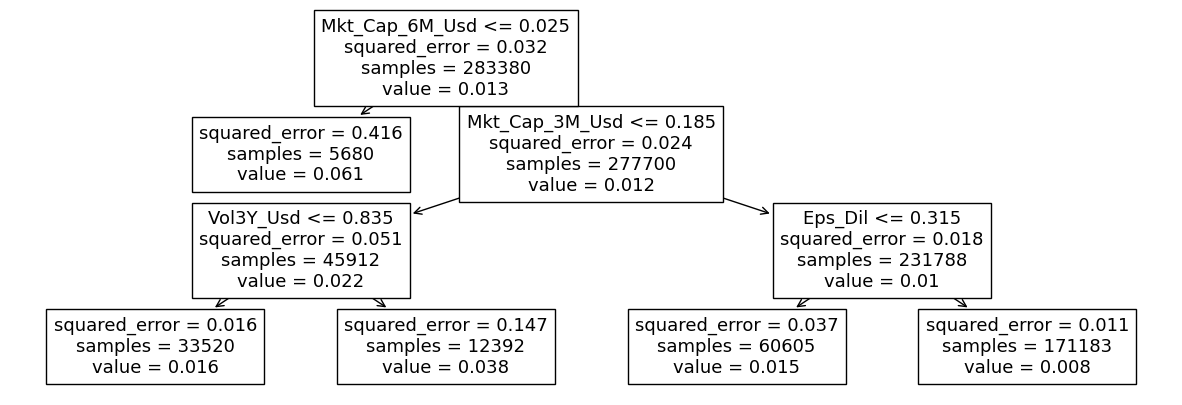

In [ ]:
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

fit_tree = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 8000, # Min nb of obs required to continue splitting 
  max_depth = 3, # Maximum depth (i.e. tree levels)
  ccp_alpha = 0.000001, # complexity parameters
  min_samples_leaf = 3500 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree.fit(X, y) # Fitting the model
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(fit_tree,feature_names=X.columns.values, ax=ax) # Plot the tree
plt.show()

In [113]:
y_pred=fit_tree.predict(X.iloc[0:6,:])   # Test (prediction) on the first six instances of the sample
y_pred

array([0.01453468, 0.01453468, 0.01453468, 0.03834095, 0.03834095,
       0.03834095])

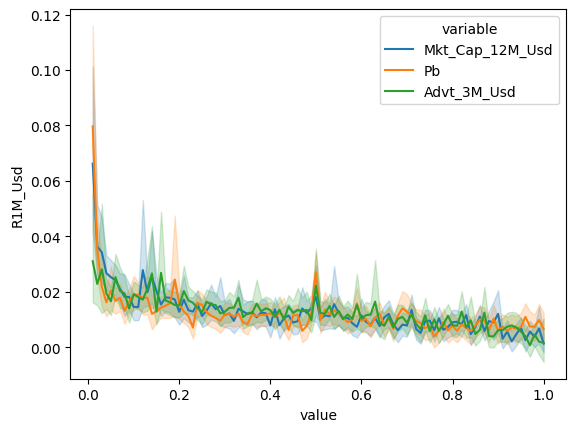

In [114]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Pb','Advt_3M_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

In [115]:
features = X.columns.values.tolist()
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]

y_train = training_sample['R1M_Usd'].values # regression target
X_train = training_sample[features].values

X_test = testing_sample[features].values
y_test = testing_sample['R1M_Usd'].values

fit_tree2 = tree.DecisionTreeRegressor( # Defining the model
  min_samples_split = 4000, # Min nb of obs required to continue splitting
  max_depth = 5, # Maximum depth (i.e. tree levels)
  ccp_alpha=0.0001, # complexity parameters
  min_samples_leaf =1500 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree2 = fit_tree2.fit(X_train, y_train) # Fitting the model

mse = np.mean((fit_tree2.predict(X_test) - y_test)**2)
print(f'MSE: {mse}')

hitratio = np.mean(fit_tree2.predict(X_test) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.03413808354246756
Hit Ratio: 0.558728361106617


## 6.2 Random forests

In [143]:
fit_RF = RandomForestRegressor(
    n_estimators = 40, # Nb of random trees
    criterion ='squared_error', # function to measure the quality of a split
    min_samples_split= 250, # Minimum size of terminal cluster
    bootstrap=True, # replacement
    max_features=30, # Nb of predictive variables for each tree
    max_samples=10000 # Size of (random) sample for each tree
)

fit_RF.fit(X_train, y_train) # Fitting the model
fit_RF.predict(pd.DataFrame(X_test).iloc[0:5,]) # Prediction over the first 5 test instances 


array([0.05796722, 0.05524206, 0.0625872 , 0.03366994, 0.06153465])

In [144]:
mse = mean_squared_error(y_test, fit_RF.predict(X_test))
hitratio = np.mean(fit_RF.predict(X_test) * y_test > 0)

print(f'MSE: {mse}')
print(f'Hit Ratio: {hitratio}')

MSE: 0.033959765893986936
Hit Ratio: 0.5485705040793214


In [117]:
# Classification labels: up (1) if return > 0 else 0
y_c_train = training_sample['R1M_Usd_C'].values # classification target
y_c_test = testing_sample['R1M_Usd_C'].values

fit_RF_C = RandomForestClassifier( 
n_estimators = 40, # Nb of random trees
criterion ='gini', # function to measure the quality of a split
min_samples_split= 250, # Minimum size of terminal cluster
bootstrap=True, # replacement
max_features=30, # Nb of predictive variables for each tree
max_samples=30000 # Size of (random) sample for each tree
)
fit_RF_C=fit_RF_C.fit(X_train, y_c_train) # Fitting the model

hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5537707721820325


## 6.3 Boosted trees: Adaboost

In [118]:
fit_adaboost_C = AdaBoostClassifier(DecisionTreeClassifier(
        max_depth=3), # depth of the tree
        n_estimators=3) # Number of trees 
fit_adaboost_C.fit(X_train, y_c_train) # Fitting the model

,estimator,DecisionTreeC...r(max_depth=3)
,n_estimators,3
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [119]:
hitratio=accuracy_score(y_c_test, fit_adaboost_C.predict(X_test)) # Hitratio
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.558728361106617


## 6.4 Boosted trees: extreme gradient boosting
### 6.4.6 Code and results

In [120]:
# Define features and separation mask
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
separation_mask = data_ml['date'] < separation_date

data_ml['R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(         # creating quantile... 
        lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)) # ...for selecting extreme values

boolean_quantile=(data_ml.loc[separation_mask]['R1M_Usd_quantile'].        # boolean array for selecting rows
                  values<=0.2) | (data_ml.loc[separation_mask]['R1M_Usd_quantile'].values>=0.8) # selecting extreme values

train_features_xgb=training_sample.loc[boolean_quantile,features_short] # Independent variables
train_label_xgb=training_sample.loc[boolean_quantile,'R1M_Usd'] # Dependent variable
train_matrix_xgb=xgb.DMatrix(train_features_xgb, label=train_label_xgb) # XGB format!

In [121]:
mono_const="(0, 0, -1, 1, 0, -1, 0)" # Initialize the vector -- "-1" == decreasing, "+1" increasing 
# Decreasing in market cap -- mono_const[2]
# Increasing in past return -- mono_const[3]
# Decreasing in price-to-book -- mono_const[5]

In [122]:
params = {
    # General Booster Parameters
    'booster' : 'dart',         # Explicitly set to DART to enable 'rate_drop'
    'objective' : "reg:squarederror", # Objective function
    'eta' : 0.3,               # Learning rate
    
    # Tree Structure and Pruning
    'max_depth' : 4,            # Max depth of each tree
    'gamma' : 0.1,              # Penalization of number of leaves (pruning).
    'lambda' : 1.0,             # L2 regularization on leaf weights (w^2)
    'monotone_constraints' : mono_const, # Monotonicity constraints

    # Subsampling/Regularization
    'subsample' : 0.6,          # Train on random 60% of sample
    'colsample_bytree' : 0.7,   # Train on random 70% of predictors

    # DART Specific Parameters
    'rate_drop' : 0.1,          # Dropout rate for DART
    'skip_drop' : 0.5,          # Probability of skipping the dropout procedure for DART
}

fit_xgb =xgb.train(params, train_matrix_xgb)

In [123]:
test_features_xgb=testing_sample[features_short] # Test sample => XGB format
test_matrix_xgb=xgb.DMatrix(test_features_xgb, label=y_test) # XGB format!

fit_xgb.predict(test_matrix_xgb)
mse = np.mean((fit_xgb.predict(test_matrix_xgb) - y_test)**2)
print(f'MSE: {mse}')

hitratio = np.mean(fit_xgb.predict(test_matrix_xgb) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.03387691083410983
Hit Ratio: 0.5575496336700025


In [124]:
train_label_xgb_C = training_sample.loc[boolean_quantile, 'R1M_Usd_C'] # Dependent variable
train_matrix_xgb_C = xgb.DMatrix(train_features_xgb, label=train_label_xgb_C) # XGB format!

In [138]:
params_C={
    'eta' : 0.01,                         # Learning rate
    'objective' : "multi:softmax",        # Objective function
    'max_depth' : 4,                      # Maximum depth of trees
    'num_class' : 2,                      # number of classes
}

fit_xgb_C =xgb.train(params_C, train_matrix_xgb_C)

hitratio = np.mean(fit_xgb_C.predict(test_matrix_xgb) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.558728361106617


### 6.4.7 Instance weighting

In [139]:
inst_weights = np.random.uniform(0,1,(train_features_xgb.shape[0],1)) # Random weights   
train_matrix_xgb=xgb.DMatrix(
    train_features_xgb,
    label=train_label_xgb, # XGB format
    weight = inst_weights  # weights
    )        

## 6.6 Coding exercices

#### 1. Using the formula in the chunks above, build two simple trees on the training sample with only one parameter: cp. For the first tree, take cp=0.001 and for the second take cp=0.01. Evaluate the performance of both models on the testing sample. Comment.

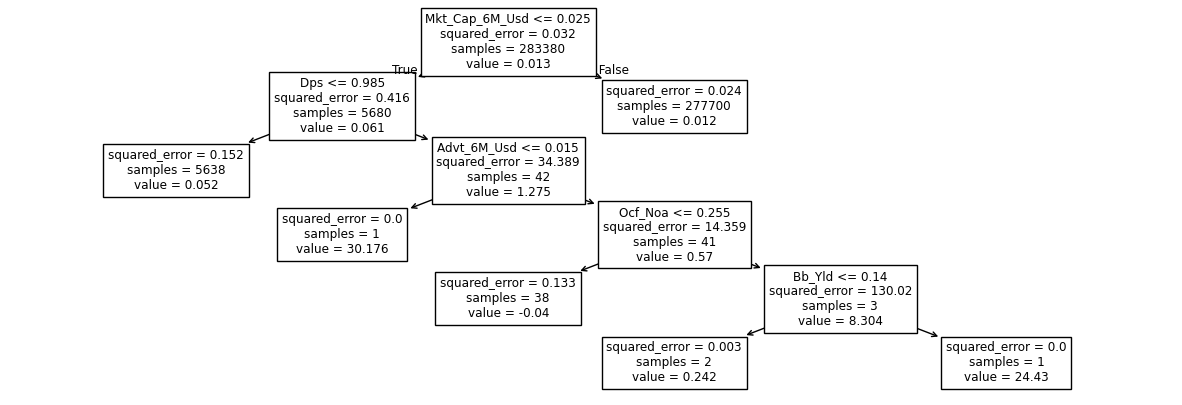

In [141]:
# Tree with cp = 0.001
fit_tree = tree.DecisionTreeRegressor(ccp_alpha=0.001)
fit_tree.fit(X, y) # Fitting the model
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(fit_tree,feature_names=X.columns.values, ax=ax) # Plot the tree
plt.show()

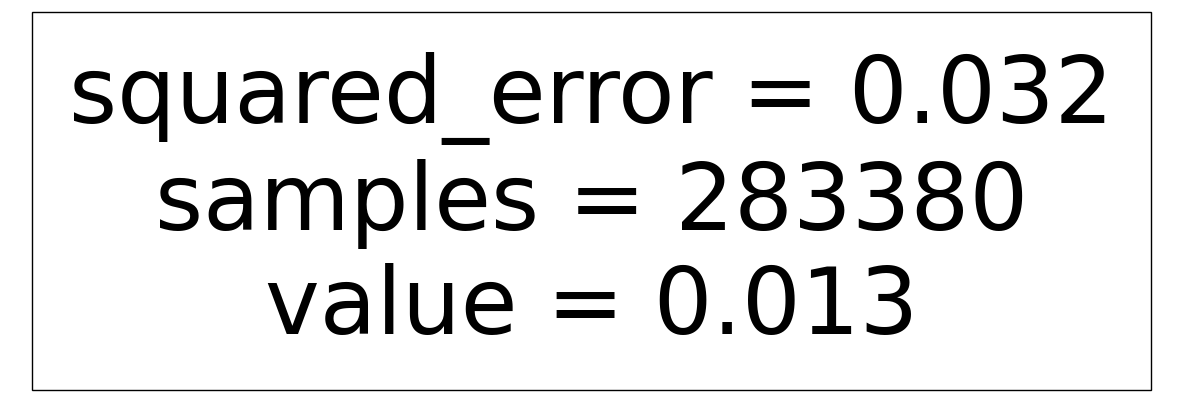

In [142]:
# Tree with cp = 0.01
fit_tree = tree.DecisionTreeRegressor(ccp_alpha=0.01)
fit_tree.fit(X, y) # Fitting the model
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(fit_tree,feature_names=X.columns.values, ax=ax) # Plot the tree
plt.show()

Both models perform poorly because they lack of parameters, especially min_samples_split, and min_samples_leaf, leading to unequal split with small branches and small leafs. However, to compare the isolated impacts of the complexity parameter, we observe that ccp_alpha=0.001 deliver better results than ccp_alpha=0.01. When the complexity parameter is too high there is no split, so no tree.

#### 2. With the smaller set of predictors, build random forests on the training sample. Restrict the learning on 30,000 instances and over 5 predictors. Construct the forests on 10, 20, 40, 80 and 160 trees and evaluate their performance on the training sample. Is complexity worthwhile in this case and why?



In [146]:
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]

X_train = training_sample[features_short].values
y_train = training_sample['R1M_Usd'].values

estimators = [10, 20, 40, 80, 160]
for n_trees in estimators:
    fit_RF = RandomForestRegressor(
        n_estimators=n_trees,
        criterion='squared_error',
        bootstrap=True,
        max_features=5,
        max_samples=30000,
        random_state=42,
    )
    fit_RF.fit(X_train, y_train)
    preds_train = fit_RF.predict(X_train)
    mse_train = mean_squared_error(y_train, preds_train)
    hitratio_train = np.mean(preds_train * y_train > 0)
    print(f"{n_trees} trees - MSE (train): {mse_train:.6f} | Hit Ratio (train): {hitratio_train:.4f}")

10 trees - MSE (train): 0.026198 | Hit Ratio (train): 0.6179
20 trees - MSE (train): 0.024743 | Hit Ratio (train): 0.6464
20 trees - MSE (train): 0.024743 | Hit Ratio (train): 0.6464
40 trees - MSE (train): 0.024132 | Hit Ratio (train): 0.6769
40 trees - MSE (train): 0.024132 | Hit Ratio (train): 0.6769
80 trees - MSE (train): 0.023286 | Hit Ratio (train): 0.7020
80 trees - MSE (train): 0.023286 | Hit Ratio (train): 0.7020
160 trees - MSE (train): 0.022618 | Hit Ratio (train): 0.7167
160 trees - MSE (train): 0.022618 | Hit Ratio (train): 0.7167


We can observe that performance improve with complexity so yes, complexity is worthwile. Increasing the numbers of base learners in the ensemble reduces variance and error rate and leads to better results. However we shouldn't evaluate the performance on the train set but on the test set to see if it really improve performance or if it just overfits.

In [147]:
for n_trees in estimators:
    fit_RF = RandomForestRegressor(
        n_estimators=n_trees,
        criterion='squared_error',
        bootstrap=True,
        max_features=5,
        max_samples=30000,
        random_state=42,
    )
    fit_RF.fit(X_train, y_train)
    preds_test = fit_RF.predict(X_test)
    mse_test = mean_squared_error(y_test, preds_test)
    hitratio_test = np.mean(preds_test * y_test > 0)
    print(f"{n_trees} trees - MSE (test): {mse_test:.6f} | Hit Ratio (test): {hitratio_test:.4f}")

10 trees - MSE (test): 0.038452 | Hit Ratio (test): 0.5107
20 trees - MSE (test): 0.037026 | Hit Ratio (test): 0.5136
20 trees - MSE (test): 0.037026 | Hit Ratio (test): 0.5136
40 trees - MSE (test): 0.035489 | Hit Ratio (test): 0.5207
40 trees - MSE (test): 0.035489 | Hit Ratio (test): 0.5207
80 trees - MSE (test): 0.035271 | Hit Ratio (test): 0.5234
80 trees - MSE (test): 0.035271 | Hit Ratio (test): 0.5234
160 trees - MSE (test): 0.034787 | Hit Ratio (test): 0.5281
160 trees - MSE (test): 0.034787 | Hit Ratio (test): 0.5281


The performance on test set confirmed what we said before on training set. MSE reduces on test set with complexity increasing so it doesn't overfit.

#### 3. Plot a tree based on data from calendar year 2008 and then from 2009. Compare.

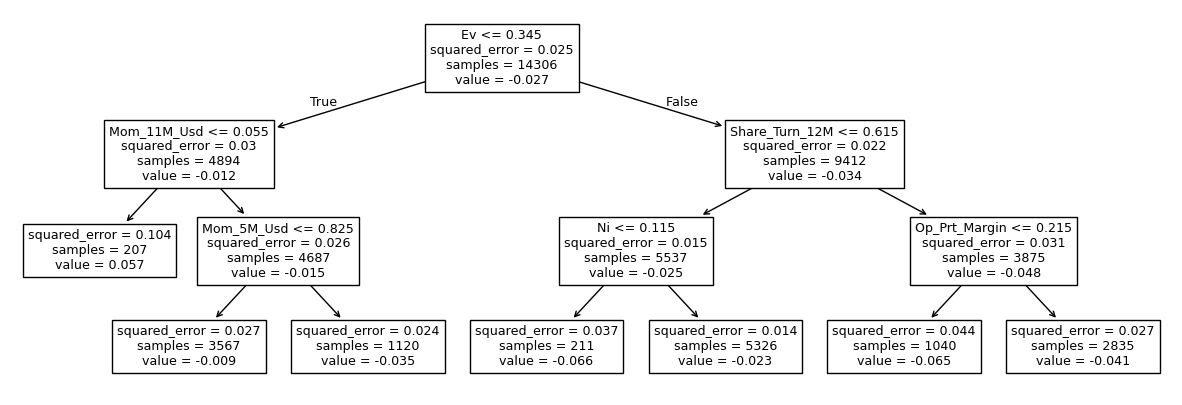

In [157]:
# 2008
mask_2008 = (data_ml['date'] >= pd.to_datetime('2008-01-01')) & (data_ml['date'] < pd.to_datetime('2009-01-01'))

X = data_ml.iloc[:,3:95].loc[mask_2008]
y = data_ml['R1M_Usd'].loc[mask_2008]

fit_tree = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 400, # Min nb of obs required to continue splitting 
  max_depth = 3, # Maximum depth
  ccp_alpha = 0.000001, # complexity parameters
  min_samples_leaf = 200 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree.fit(X, y) # Fitting the model
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(fit_tree,feature_names=X.columns.values, ax=ax) # Plot the tree
plt.show()

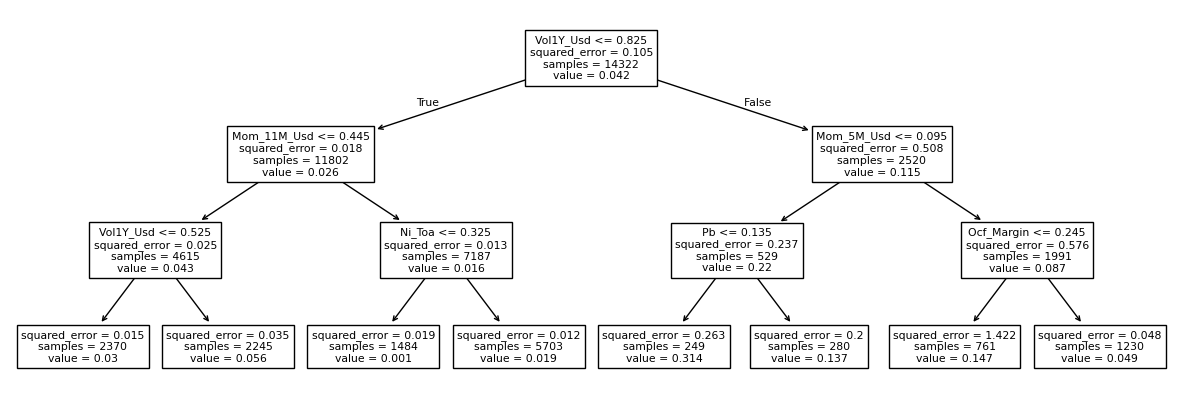

In [158]:
# 2009
mask_2009 = (data_ml['date'] >= pd.to_datetime('2009-01-01')) & (data_ml['date'] < pd.to_datetime('2010-01-01'))

X = data_ml.iloc[:,3:95].loc[mask_2009]
y = data_ml['R1M_Usd'].loc[mask_2009]

fit_tree = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 400, # Min nb of obs required to continue splitting 
  max_depth = 3, # Maximum depth
  ccp_alpha = 0.000001, # complexity parameters
  min_samples_leaf = 200 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree.fit(X, y) # Fitting the model
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(fit_tree,feature_names=X.columns.values, ax=ax) # Plot the tree
plt.show()

We observe that in 2008 the best predictor for 1M returns was the Enterprise Value and that it was quite efficient (4.9k/9.4k split) while in 2009 it was the 1Y volatility and it was less efficient (11.8k/2.5k split).This can be explicated by
1. In 2008: the fact that the small caps performed better than large caps during the GFC, impacted by the systemic risk
2. In 2009: the companies that suffered the most in 2008 (high 1Y vol), "rebound" in 2009, leading to higher performance in 2009 than the more defensive companies that were less impacted the previous year.